# Part 2: MLP Solves XOR, Activations, Universal Approximation, TensorFlow Gradients

This notebook continues from the perceptron/XOR discussion.
You will:
1. Train an **MLP** to solve **XOR**
2. Visualize and compare **activation functions** and see why nonlinearity matters
3. Understand the **Universal Approximation Theorem** (with a mini demo)
4. Use **`tf.GradientTape`** to perform a manual training step


## 1) MLP Solves XOR
**Idea:** Add a hidden layer with a nonlinear activation (e.g., `tanh` or `relu`).

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final accuracy on XOR: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predictions: [0 1 0 1]
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


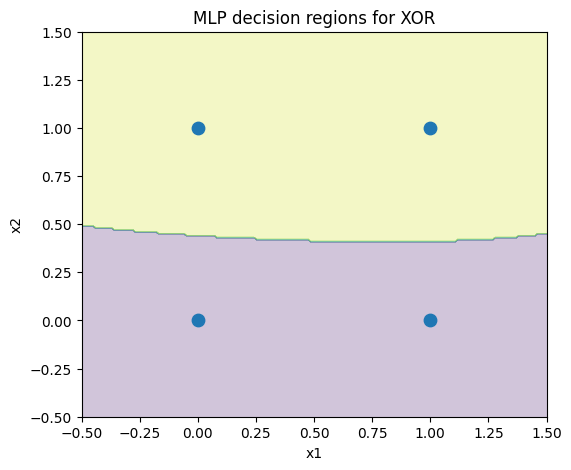

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y = np.array([[0],[1],[1],[0]], dtype=np.float32)

model = Sequential([
    Dense(4, activation='tanh', input_shape=(2,)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=400, verbose=0)
acc = model.evaluate(X, y, verbose=0)[1]
print('Final accuracy on XOR:', acc)
print('Predictions:', (model.predict(X) > 0.5).astype(int).ravel())

# Visualize decision regions (single plot)
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
zz = (model.predict(grid) > 0.5).astype(int).reshape(xx.shape)
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, zz, alpha=0.25)
plt.scatter(X[:,0], X[:,1], s=80)
plt.title('MLP decision regions for XOR')
plt.xlabel('x1'); plt.ylabel('x2')
plt.show()

## 2) Activation Functions: Why Nonlinearity Matters
- With **no** nonlinear activation, stacked layers collapse to a single linear mapping.
- Common activations: **step**, **sigmoid**, **tanh**, **ReLU**.
- Below we plot their shapes (one plot per figure) and train XOR with and without nonlinearity.

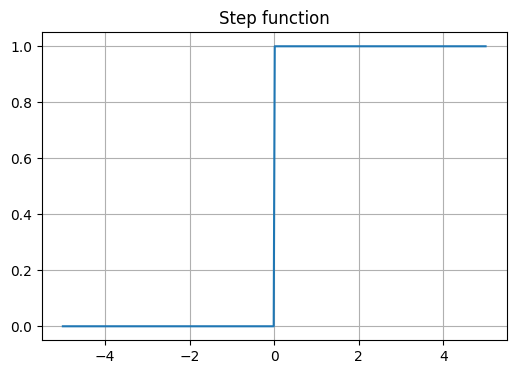

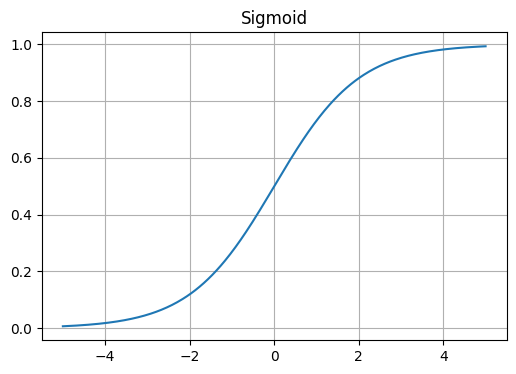

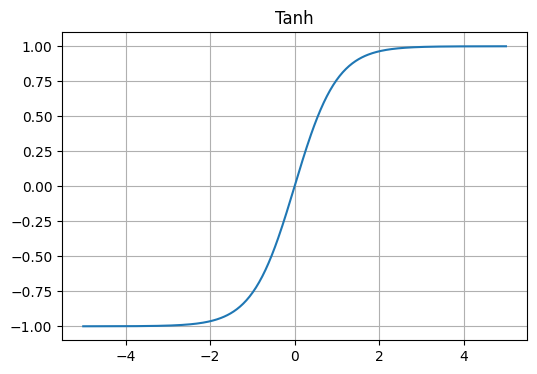

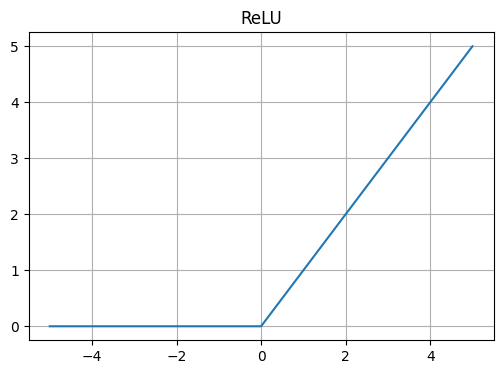

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 400)

# Step (for visualization only)
y_step = (x >= 0).astype(float)
plt.figure(figsize=(6,4))
plt.plot(x, y_step)
plt.title('Step function')
plt.grid(True)
plt.show()

# Sigmoid
y_sig = 1/(1+np.exp(-x))
plt.figure(figsize=(6,4))
plt.plot(x, y_sig)
plt.title('Sigmoid')
plt.grid(True)
plt.show()

# Tanh
y_tanh = np.tanh(x)
plt.figure(figsize=(6,4))
plt.plot(x, y_tanh)
plt.title('Tanh')
plt.grid(True)
plt.show()

# ReLU
y_relu = np.maximum(0, x)
plt.figure(figsize=(6,4))
plt.plot(x, y_relu)
plt.title('ReLU')
plt.grid(True)
plt.show()

### XOR with a Linear Network (no nonlinearity) — will fail
We make the hidden layer use a linear activation to show it cannot solve XOR.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y = np.array([[0],[1],[1],[0]], dtype=np.float32)

linear_model = Sequential([
    Dense(4, activation='linear', input_shape=(2,)),
    Dense(1, activation='linear')
])
linear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                     loss='mse', metrics=['accuracy'])
history = linear_model.fit(X, y, epochs=400, verbose=0)
print('Linear net accuracy on XOR (expected low):', linear_model.evaluate(X, y, verbose=0)[1])
print('Predictions:', (linear_model.predict(X) > 0.5).astype(int).ravel())

Linear net accuracy on XOR (expected low): 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predictions: [1 0 1 0]


## 3) Universal Approximation Theorem (UAT)
**Informal statement:** A feedforward network with one hidden layer and a nonlinear activation can approximate any continuous function on a compact interval, as closely as you wish, given enough hidden units.

### Mini Demo: Approximating `sin(x)`
We fit a small MLP to sample points from `sin(x)` and visualize the fit.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


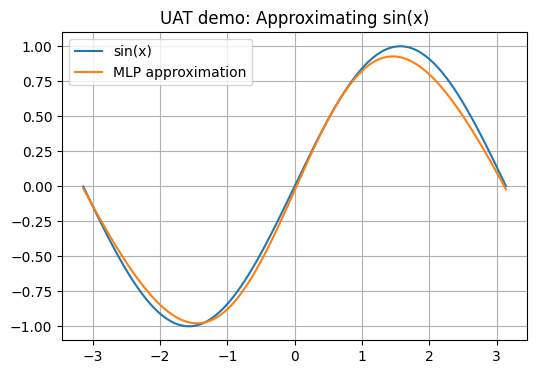

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

rng = np.random.RandomState(0)
xs = np.linspace(-3.14, 3.14, 200).astype(np.float32)
ys = np.sin(xs)[:, None]

reg = Sequential([
    Dense(32, activation='tanh', input_shape=(1,)),
    Dense(1, activation='linear')
])
reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
reg.fit(xs[:, None], ys, epochs=300, verbose=0)
pred = reg.predict(xs[:, None])

plt.figure(figsize=(6,4))
plt.plot(xs, ys, label='sin(x)')
plt.plot(xs, pred, label='MLP approximation')
plt.title('UAT demo: Approximating sin(x)')
plt.legend()
plt.grid(True)
plt.show()

## 4) TensorFlow `GradientTape`: Manual Training Step
Below we do a single optimization step with gradients on the XOR problem. This connects the **derivative** idea to actual weight updates.

In [5]:
import numpy as np
import tensorflow as tf

X = tf.constant([[0.,0.],[0.,1.],[1.,0.],[1.,1.]], dtype=tf.float32)
y = tf.constant([[0.],[1.],[1.],[0.]], dtype=tf.float32)

# Simple MLP
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn = tf.keras.losses.BinaryCrossentropy()

with tf.GradientTape() as tape:
    y_pred = model(X, training=True)
    loss = loss_fn(y, y_pred)
grads = tape.gradient(loss, model.trainable_variables)
optimizer.apply_gradients(zip(grads, model.trainable_variables))
print('One training step done. Loss:', float(loss.numpy()))

One training step done. Loss: 0.7067596912384033
